# Daily Tmax Evaluation Analysis

This notebook loads evaluation results and generates diagnostic plots:
- Residual distributions
- MAE by month/season
- Calibration coverage vs nominal
- Error by lead time

In [1]:
import sys
sys.path.insert(0, '../src')

import json
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from tempdata.eval import load_run, list_runs

# Style settings
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('viridis')

## 1. Run Evaluation

First, run the evaluation via CLI (or uncomment to run here):

In [2]:
# Run evaluation from CLI (recommended)
!python ../scripts/eval_daily_tmax.py --config ../configs/eval_klga_v1.json

# Or run programmatically:
# from tempdata.eval import EvalConfig, run_evaluation
# config = EvalConfig.load('../configs/eval_klga_v1.json')
# result = run_evaluation(config, forecast_df, truth_df)

[eval] Loading data...
[eval] Loaded 5117 Open-Meteo rows for 2016+ period
[eval] Loaded 3654 ISD truth rows for pre-Aug-2025

DAILY TMAX EVALUATION: 20260120_093258
Run name: eval_klga_ridge_v1
Stations: KLGA
Date range: 2015-01-01 to 2025-01-01

[eval] Loading data...

EVALUATION DATA SUMMARY

Total samples:    5,117
Training samples: 3,581 (70.0%)
Validation:       768 (15.0%)
Test samples:     768 (15.0%)

Date range: 2017-12-31 to 2025-01-01
Stations: KLGA

Feature columns (17): lat, lon, tmax_pred_c, tmax_pred_f, lead_hours...

[eval] Fitting model...
[eval] Generating predictions...
[eval] Computing metrics...

EVALUATION METRICS SUMMARY

--- FORECAST PERFORMANCE ---
  Samples:     768
  MAE:         1.23°F
  RMSE:        1.51°F
  Bias:        +0.78°F
  Std Error:   1.29°F

--- CALIBRATION ---
  Mean σ:      1.60°F
  50% PI cov:  50.0% (target: 50%)
  80% PI cov:  83.3% (target: 80%)
  90% PI cov:  92.7% (target: 90%)
  90% width:   5.3°F

[eval] Writing artifacts...

Run comple

## 2. Load Run Artifacts

In [3]:
# List available runs
runs = list_runs(Path('../runs'))
print(f"Available runs ({len(runs)}):")
for r in runs[:5]:
    print(f"  - {r['run_id']}: {r.get('run_name', 'N/A')}")

Available runs (4):
  - 20260120_093258: eval_klga_ridge_v1
  - 20260120_084613: eval_KLGA
  - 20260120_084553: eval_KLGA
  - 20260119_225838: eval_klga_ridge_v1


In [4]:
# Load latest run (or specify a run_id)
run_id = runs[0]['run_id'] if runs else None
if run_id:
    run_data = load_run(run_id, Path('../runs'))
    predictions_df = run_data['predictions_df']
    residuals_df = run_data['residuals_df']
    metrics = run_data['metrics']
    slices = run_data.get('slices', {})
    print(f"Loaded run: {run_id}")
    print(f"Samples: {len(predictions_df):,}")
else:
    print("No runs available. Run evaluation first.")

Loaded run: 20260120_093258
Samples: 768


In [5]:
def save_run_plot(fig, filename, run_id, base_dir=Path('../runs')):
    """Save figure to the run's plot directory."""
    if not run_id:
        return

    plot_dir = base_dir / run_id / "plots"
    plot_dir.mkdir(exist_ok=True, parents=True)

    out_path = plot_dir / filename
    fig.savefig(out_path, dpi=300, bbox_inches='tight')
    print(f"Saved plot: {out_path}")


## 3. Metrics Summary

In [6]:
if run_id:
    print("=" * 50)
    print("FORECAST PERFORMANCE")
    print("=" * 50)
    fm = metrics['forecast']
    print(f"MAE:  {fm['mae']:.2f}°F")
    print(f"RMSE: {fm['rmse']:.2f}°F")
    print(f"Bias: {fm['bias']:+.2f}°F")

    if 'calibration' in metrics:
        print("\nCALIBRATION")
        cm = metrics['calibration']
        print(f"90% coverage: {100*cm['coverage_90']:.1f}% (target: 90%)")
        print(f"Mean sigma: {cm['mean_sigma']:.2f}°F")

FORECAST PERFORMANCE
MAE:  1.23°F
RMSE: 1.50°F
Bias: +0.78°F

CALIBRATION
90% coverage: 92.7% (target: 90%)
Mean sigma: 1.60°F


## 4. Residual Analysis

Saved plot: ../runs/20260120_093258/plots/residual_analysis.png


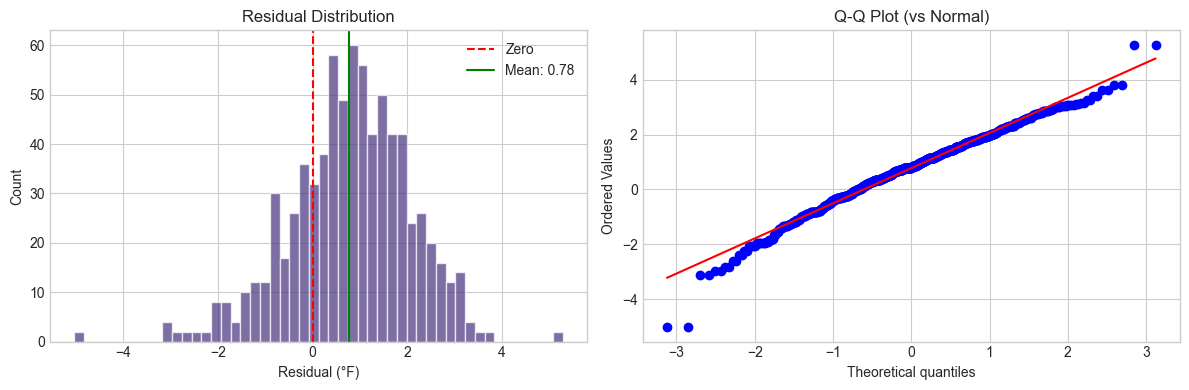

In [7]:
if run_id:
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))

    # Residual histogram
    ax = axes[0]
    residuals = residuals_df['residual_f']
    ax.hist(residuals, bins=50, edgecolor='white', alpha=0.7)
    ax.axvline(0, color='red', linestyle='--', label='Zero')
    ax.axvline(residuals.mean(), color='green', linestyle='-', label=f'Mean: {residuals.mean():.2f}')
    ax.set_xlabel('Residual (°F)')
    ax.set_ylabel('Count')
    ax.set_title('Residual Distribution')
    ax.legend()

    # Q-Q plot
    ax = axes[1]
    from scipy import stats
    stats.probplot(residuals, dist='norm', plot=ax)
    ax.set_title('Q-Q Plot (vs Normal)')

    plt.tight_layout()
    save_run_plot(fig, 'residual_analysis.png', run_id)
    plt.show()

## 5. MAE by Month

Saved plot: ../runs/20260120_093258/plots/mae_by_month.png


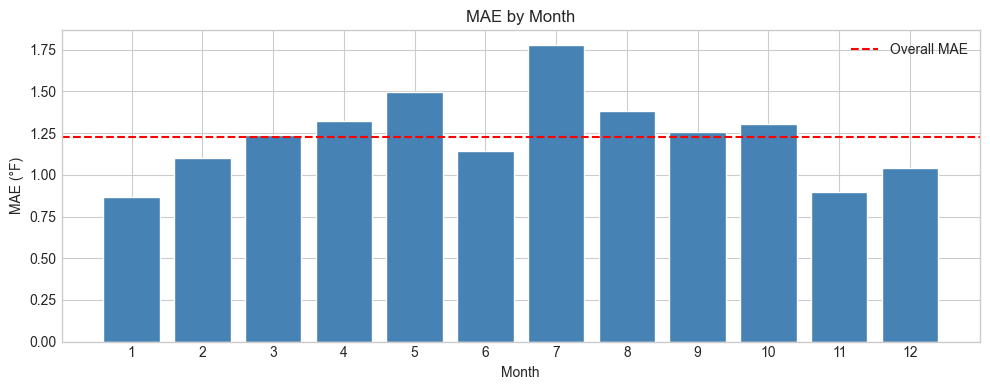

In [8]:
if run_id and 'by_month' in slices:
    by_month = slices['by_month']
    months = sorted(by_month.keys(), key=int)
    maes = [by_month[m]['mae'] for m in months]

    fig, ax = plt.subplots(figsize=(10, 4))
    ax.bar(months, maes, color='steelblue', edgecolor='white')
    ax.axhline(metrics['forecast']['mae'], color='red', linestyle='--', label='Overall MAE')
    ax.set_xlabel('Month')
    ax.set_ylabel('MAE (°F)')
    ax.set_title('MAE by Month')
    ax.legend()
    plt.tight_layout()
    save_run_plot(fig, 'mae_by_month.png', run_id)
    plt.show()

## 6. MAE by Season

Saved plot: ../runs/20260120_093258/plots/mae_by_season.png


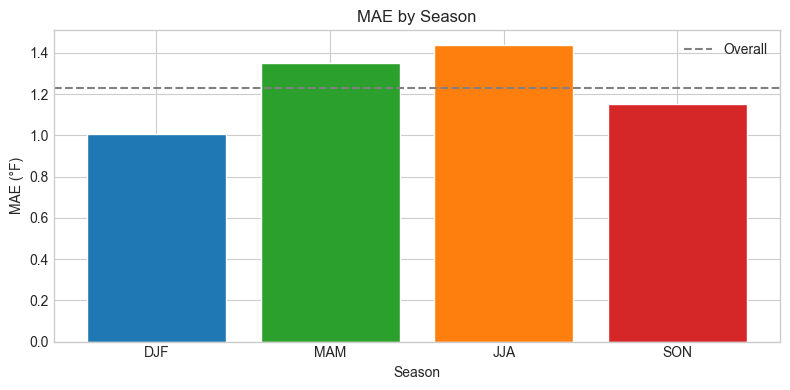

In [9]:
if run_id and 'by_season' in slices:
    by_season = slices['by_season']
    seasons = ['DJF', 'MAM', 'JJA', 'SON']
    maes = [by_season.get(s, {}).get('mae', 0) for s in seasons]

    fig, ax = plt.subplots(figsize=(8, 4))
    colors = ['#1f77b4', '#2ca02c', '#ff7f0e', '#d62728']
    ax.bar(seasons, maes, color=colors, edgecolor='white')
    ax.axhline(metrics['forecast']['mae'], color='gray', linestyle='--', label='Overall')
    ax.set_xlabel('Season')
    ax.set_ylabel('MAE (°F)')
    ax.set_title('MAE by Season')
    ax.legend()
    plt.tight_layout()
    save_run_plot(fig, 'mae_by_season.png', run_id)
    plt.show()

## 7. Calibration Plot

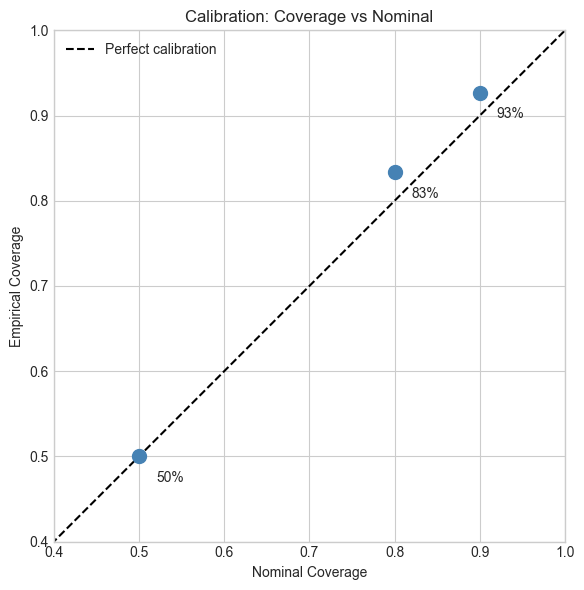

In [10]:
if run_id and 'calibration' in metrics:
    cm = metrics['calibration']

    nominals = [0.5, 0.8, 0.9]
    coverages = [cm['coverage_50'], cm['coverage_80'], cm['coverage_90']]

    fig, ax = plt.subplots(figsize=(6, 6))
    ax.plot([0, 1], [0, 1], 'k--', label='Perfect calibration')
    ax.scatter(nominals, coverages, s=100, c='steelblue', zorder=5)
    for n, c in zip(nominals, coverages):
        ax.annotate(f'{100*c:.0f}%', (n + 0.02, c - 0.03))
    ax.set_xlabel('Nominal Coverage')
    ax.set_ylabel('Empirical Coverage')
    ax.set_title('Calibration: Coverage vs Nominal')
    ax.set_xlim(0.4, 1)
    ax.set_ylim(0.4, 1)
    ax.legend()
    ax.set_aspect('equal')
    plt.tight_layout()
    plt.show()

## 8. Prediction vs Actual Scatter

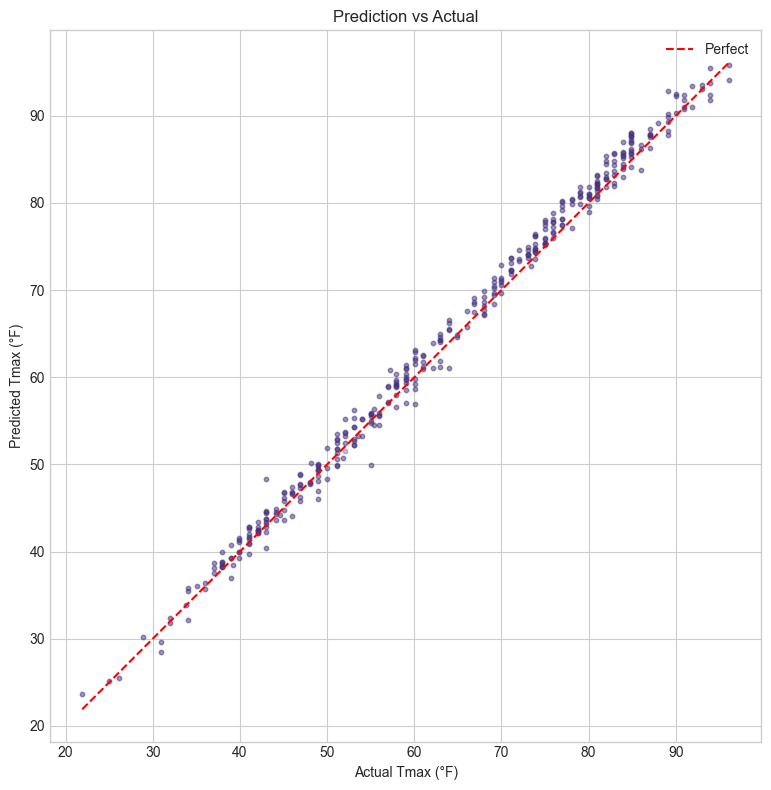

In [11]:
if run_id:
    fig, ax = plt.subplots(figsize=(8, 8))

    x = predictions_df['y_true_f']
    y = predictions_df['y_pred_f']

    ax.scatter(x, y, alpha=0.3, s=10)

    # Perfect line
    lims = [min(x.min(), y.min()), max(x.max(), y.max())]
    ax.plot(lims, lims, 'r--', label='Perfect')

    ax.set_xlabel('Actual Tmax (°F)')
    ax.set_ylabel('Predicted Tmax (°F)')
    ax.set_title('Prediction vs Actual')
    ax.legend()
    ax.set_aspect('equal')
    plt.tight_layout()
    plt.show()